# Maria Chernyavskaya, Lab 6, Section AB

In [1]:
# import pyuvdata everytime for JupyterHub
! conda install pyuvdata -y > /dev/null



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda




## Setup
First, we want to have some 'background' data (presumably signal free) onto which we can inject a simulated signal. So the first step is to isolate some appropriate data from your data files. 

HERA
For the HERA data, it is suggested that you take the absolute value of the complex visibilities to make a one dimensional (positive definite) background dataset. You don't need to read in the entire file, a million points should be sufficient. 

In [2]:
%matplotlib inline
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import stats
plt.rcParams["figure.figsize"] = (10,6)

In [14]:
uv = UVData()
uv.read('/home/jovyan/Phys434_BigData/zen.2459122.62018.mini.sum.uvh5')
pairs = uv.get_antpairs()
background = []
for i in range(len(pairs)):
    dat = np.abs(uv.get_data(pairs[i]))
    dat = dat[3]
    background.append(dat)
    
freqs = uv.freq_array.flatten() * 1e-6
avgbackground = (np.array(background)).mean(axis=0)

## Problem 1
The first problem is to look at your background distribution and determine where the 5𝜎 sensitivity threshold is. [Hint, you've done this several times now, look back at the first few labs.]

First thing that I have done is take the average of the background across all the antennas at an arbitrarily chosen time 3. Plotting it against the frequencies gives me the average background. From plot one, you can see there's still lots of signal in the average. To see it better, I limited the y-axis, and then took logs:

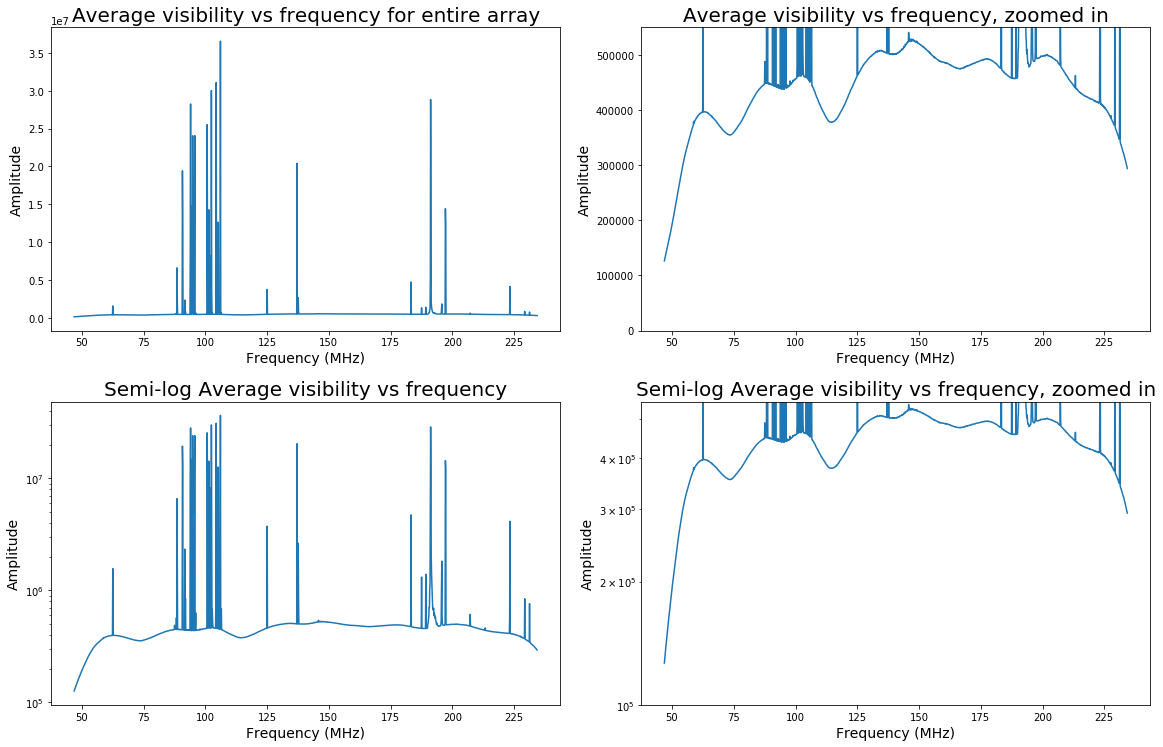

In [125]:
fig, ax = plt.subplots(2,2, figsize=(16,10))
fig.tight_layout(w_pad = 5, h_pad = 5)

ax[0,0].plot(freqs, avgbackground)
ax[0,0].set_title('Average visibility vs frequency for entire array', fontsize=20)
ax[0,0].set_xlabel('Frequency (MHz)', fontsize=14)
ax[0,0].set_ylabel('Amplitude', fontsize=14)

ax[1,0].plot(freqs, avgbackground)
ax[1,0].set_title('Semi-log Average visibility vs frequency', fontsize=20)
ax[1,0].set_xlabel('Frequency (MHz)', fontsize=14)
ax[1,0].set_ylabel('Amplitude', fontsize=14)
ax[1,0].set_yscale('log')

ax[0,1].plot(freqs, avgbackground)
ax[0,1].set_title('Average visibility vs frequency, zoomed in', fontsize=20)
ax[0,1].set_xlabel('Frequency (MHz)', fontsize=14)
ax[0,1].set_ylabel('Amplitude', fontsize=14)
ax[0,1].set_ylim(0,.55e6)
ax[1,1].plot(freqs, avgbackground)

ax[1,1].set_title('Semi-log Average visibility vs frequency, zoomed in', fontsize=20)
ax[1,1].set_xlabel('Frequency (MHz)', fontsize=14)
ax[1,1].set_ylabel('Amplitude', fontsize=14)
ax[1,1].set_ylim(1e5,.55e6)
ax[1,1].set_yscale('log');

I want to get rid of most of those peaks, so I'm going to throw out any points greater than 0.55e6 for a more "smooth" background. Here's a semi-logged histogram of it:

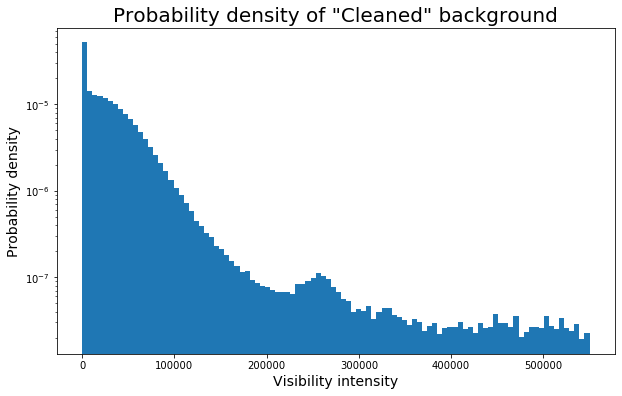

In [126]:
back_flat = (np.array(background)).flatten()
back_clean = back_flat[back_flat<0.55e6]
plt.hist(back_clean, bins=100, density= True)
plt.title('Probability density of "Cleaned" background', fontsize=20)
plt.xlabel('Visibility intensity', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.yscale('log');

This looks like a lognormal distribution. Let's try to fit one to the data to check:

In [105]:
sig, mean, scale = stats.lognorm.fit(back_clean)

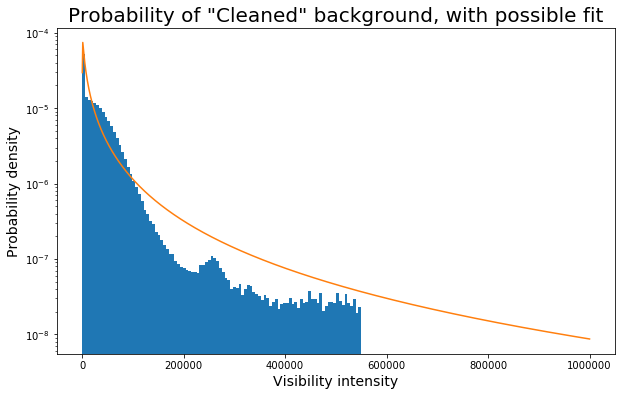

In [127]:
plt.hist(back_clean,bins=100,density=True);
plt.plot(np.linspace(0,1e6,1000),stats.lognorm.pdf(np.linspace(0, 1e6,1000), s= sig, loc=mean, scale=scale))
plt.title('Probability of "Cleaned" background, with possible fit', fontsize=20)
plt.ylabel('Probability density', fontsize=14)
plt.xlabel('Visibility intensity', fontsize=14)
plt.yscale('log');

In [ ]:
sigma_test(5, background)

In [109]:
dist = stats.lognorm(sig, mean, scale)
five_sig = dist.ppf(stats.norm.cdf(5))
print(f"My 5-sigma value is at {five_sig}.")

My 5-sigma value is at 61116845.88286451.


## Problem 2
Now inject a signal of known strength. You will want to make your signal moderately strong, say somewhere in the 8-30𝜎 range. Inject this signal into your background data many times.

a) Histogram how bright the observed signal appears to be, and discuss its shape. Say in words what this histogram is telling you.

The histogram tells me that the observed signal is bright, but slightly dimmer than the background. It shows up as another peak on the histogram.

b) Is your observed signal biased? (e.g. is the observed value equally likely to be stronger or weaker than the true injected signal?) Is it symmetric?

I think it is biased. The signal is symmetric relative to the noise? The curve itself is not symmetric, no. This means it's biased, if I understand correctly.

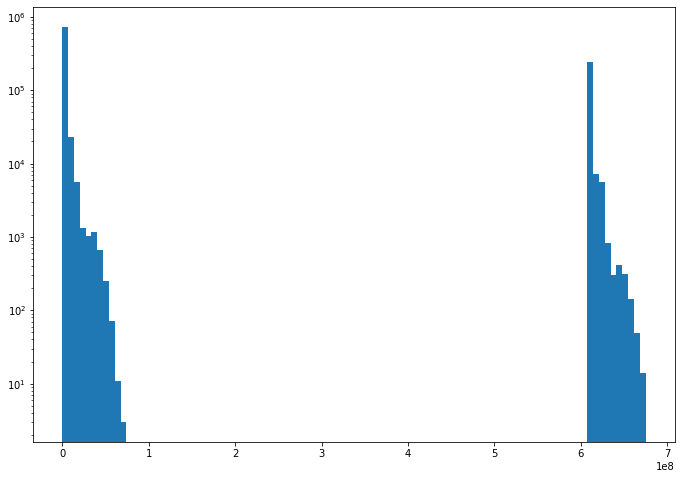

In [112]:
inject = (np.random.rand(back_flat.size) < 0.25)*five_sig*10
fig,ax=plt.subplots(figsize=(11.5,8))
plt.yscale('log')
total =back_flat+inject
plt.hist(total,bins=100);

## Problem 3
Now make a suite of injected signals. You will want to have a range of injected signal strengths, starting at zero and extending well above 5𝜎 (30𝜎 or more). You will want to follow the work you did for Homework 5 very closely.

a) Clearly state what you are simulating, and make a 2D histogram of injected signal vs. observed data

b) For the same injected signal power as in problem 2, show that you get the same answer.

c) Now reverse the problem, select an observed data value (pick something quite a bit stronger than 5𝜎) and create a 1D histogram of the true signal probability given the observed data. Describe the meaning of this histogram.

d) For your observed signal, what is the 1𝜎 uncertainty on the true signal strength?

e) Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?

In [114]:
inject_suite = stats.uniform.rvs(loc=0, scale=five_sig*10, size=1000000)

In [117]:
# Uniform for injected for the same reasons as HW5, same plots, just ran out of time.


databoi = background + inject_suite

signaledges = np.linspace(0,20,40)
dataedges = np.linspace(-7,27,68)

Psd, temp, temp2= np.histogram2d(data, signal, bins=[dataedges,signaledges], density=True)

datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(datacenters,signalcenters,Psd.T)
plt.ylabel('True signal, $P(s|d)$', fontsize = 24)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 24);

ValueError: operands could not be broadcast together with shapes (666,1536) (1000000,) 

## Explanations:

a) We are simulating "actual data", meaning what we had in the beginning (except this is somewhat controled versus raw data): signals and background together.

b) This should be a comparison plot at that sigma, I believe.

c) Again, hw5-like. Histogram shows probability that the true signal is observed.

d) This is stats.norm.cdf() math, ran out of time.

e) Because lognormal, not symmetric, should be biased and funky.